<center>
<h1>Pseudopotential-Derived Band Structure of Silicon</h1>
<br> William M. Medlar <br>
*Department of Physics, University of North Texas, Denton, Texas*
<br><br> The band structure of Silicon is calculated using the empirical pseudopotential method implemented in the Python programming <br> language.
A generalized routine is able to calculate the band structure of diamond and zincblende lattices. The energy splittings <br> for Silicon at symmetry points appear to be very accurate with accepted values by diagonalizing a 343 x 343 Hamiltonian matrix.<br>
    
</center>

## I. Introduction

The empirical pseudopotential method was developed as a tool to solve Schrodinger's equation of bulk crystals without the exact potential of an electron in a lattice -- a many body problem. Because of its simplicity and accuracy, the pseudopotential method still sees use today.

A pseudopotential mimics the potential felt by valence and conduction band electrons, well beyond the nucleus. This potential can be Fourier expanded in plane waves, giving a large eigenvalue problem. Fourier coefficients can be fitted to calculations, as in Cohen and Bergstresser$^1$, or experimentally determined.

In this paper I will form the pseudopotential Hamiltonian and implement it in the Python programming language to calculate the electronic band structure of Silicon. Calculated values are plotted and compared to accepted values, and the usefulness of the pseudopotential method is discussed.

## II. Pseudopotential Method

The pseudopotential Hamiltonian operator for an electron in a crystal takes the form:

$$
\hat{H} = \hat{T} + \hat{V} = -\frac{\hbar^2}{2m^*} \nabla^2 + V(\vec{r})
$$

Where the potential $V(\vec{r})$ is the crystal pseudopotential, and is given by a linear combination of atomic potentials. The potential is periodic and can be expanded into a Fourier series of plane waves and split into symmetric and antisymmetric parts:

$$
V(\vec{r}) = \sum\limits_{\vec{G}}^{\infty} V_{\vec{G}} \: e^{-\mathrm{i} \: \vec{G} \cdot \vec{r}}
= \sum\limits_{\vec{G}}^{\infty} \: \left(V_G^S \cos{\vec{G} \cdot \vec{\tau}} + \mathrm{i} V_G^A \sin{\vec{G} \cdot \vec{\tau}} \right) \: e^{-\mathrm{i} \: \vec{G} \cdot \vec{r}}
$$

where $V_G^S$ and $V_G^A$ are the symmetric and asymmetric form factors, respectively, unique to the pseudopotential. Following Brust's$^2$ method, form factors will only be nonzero for reciprocal lattice vectors $\vec{G}$ with magnitudes 0, 3, 4, 8, or 11.

The form factors can be interpreted by slight adjustment until the calculated band splittings match that of experimental data. Luckily these values are readily available for Silicon; I will take Cohen and Bergstresser's$^{1}$ to be accurate.

Meanwhile our kinetic component can be expressed as a summation over the reciprocal lattice vectors at any point $\vec{k}$ in the first Brillouin zone:

$$
T = \sum\limits_{\vec{G}}^{\infty} \frac{\hbar^2}{2m^*} \|\vec{k} + \vec{G}\|^2
$$

Substituting these back into the Schrodinger equation and noting that the wavefunction is a Bloch function of the form:

$$
\Psi_{\vec{k}}(\vec{r}) = e^{\mathrm{i} \: \vec{k} \cdot \vec{r}} \: u_k (\vec{r})
= e^{\mathrm{i} \: \vec{k} \cdot \vec{r}} \sum\limits_{\vec{G'}}^{\infty} \: U({\vec{G'}}) \: e^{\mathrm{i} \: \vec{G'} \cdot \vec{r}}
$$

we're left with the matrix equation:

$$
\sum\limits_{\vec{G}}^{\infty} \left[ \left( \frac{\hbar^2}{2m^*} \|\vec{k} + \vec{G}\|^2 - E \ \right) U({\vec{G}})
+ \sum\limits_{\vec{G'}}^{\infty} \: U({\vec{G'}}) \: \left(V_G^S \cos{\left( \vec{G} - \vec{G'} \right) \cdot \vec{\tau}} + \mathrm{i} V_G^A \sin{\left( \vec{G} - \vec{G'} \right) \cdot \vec{\tau}} \right) \right] = 0
$$

The energy eigenvalues of which can be found by diagonalizing our Hamiltonian.

## III. Implementation

Our Hamiltonian matrix's size is given by the number of reciprocal lattice vectors ( $\vec{G}$  and $\vec{G'}$ ) that we use, where each vector takes the form:

$$
\vec{G} = h \: \vec{b_1} + k \: \vec{b_2} + l \: \vec{b_3}
$$

Where $\vec{b_n}$ are is our reciprocal lattice basis and $h$, $k$, and $l$ are a set of integers centered around zero. For ```states=5``` they are given by the set {-2, -1, 0, 1, 2}. The calculation of $h$, $k$, and $l$ is incremented about the center of the matrix a la the Cartesian product, and was translated from Danner's$^3$ Mathematica notebook into Python.

Note that the coefficients can be, and often are, outside of their defined set, however any attempt to reimplement the calculations to their defined values was met with very strange band structures. Ultimately I conceded defeat and simply used his implementation.

In [1]:
def coefficients(m, states):
    
    n = (states**3) // 2
    s = m + n
    floor = states // 2

    h = s // states**2 - floor
    k = s % states**2 // states - floor
    l = s % states - floor

    return h, k, l

In [2]:
coefficients(4, 5)

(0, 1, -1)

The kinetic term of the Hamiltonian does not depend on $\vec{G'}$, only on $\vec{G}$. Translating this to matrix notation, our kinetic term is nonzero only along the diagonal:

$$
T_{i,j} = \frac{\hbar^2}{2m^*} \|\vec{k} + \vec{G_i}\|^2 \delta_{i,j}
$$

where $i$ and $j$ are our row and column indices, respectively, and $\delta_{i,j}$ is the Kronecker delta. For $\vec{k}$ and $\vec{G_i}$ values in units of $\frac{2 \pi}{a}$ the kinetic term is given by:

In [3]:
from scipy import constants as c

# remove constant from function definition so it is not recalculated every time
KINETIC_CONSTANT = c.hbar**2 / (2 * c.m_e * c.e)

def kinetic(k, g):
    
    v = k + g
    
    return KINETIC_CONSTANT * v @ v

With two atoms in the unit cell of the diamond (or zincblende) lattice our potential component must include both of their contributions. As per Cohen and Bergstresser$^{1}$ I will use an origin halfway between the two atoms, with one situated at $\vec{r_1} = \frac{a}{8} \left(\begin{array}{ccc}1, \ 1, \ 1\end{array}\right) = \vec{\tau}$ and the other at $\vec{r_2} = - \vec{\tau}$. The potential component is then given by:

$$
\begin{align}
V_{i,j} = V_G^S \cos{\vec{G} \cdot \vec{\tau}} + \mathrm{i} V_G^A \sin{\vec{G} \cdot \vec{\tau}}
\end{align}
$$

The unit cell of Silicon is composed only of Silicon atoms, however, and thus has no asymmetric term. I've left it commented out in the function to avoid unnecessary calculations of 0, however it can easily be uncommented to work for zincblende configurations.

In [4]:
import numpy as np

def potential(g, tau, sym, asym=0):
    
    return sym * np.cos(2 * np.pi * g @ tau) # + 1j * asym * np.sin(2 * np.pi * g @ tau)

The total Hamiltonian size will be given by $states^3 \times states^3$ where $states$ is the odd number of integer states our $h$, $k$, and $l$ coefficients can take. The ```coefficients``` function has been reimplemented in the ```hamiltonian``` function with a cache to improve the performance of our calculation.

In [5]:
import functools
import itertools

def hamiltonian(lattice_constant, form_factors, reciprocal_basis, k, states):
    
    # descriptive names are good for reading function signatures
    # but a bit of a pain for writing
    a = lattice_constant
    ff = form_factors
    basis = reciprocal_basis
    
    # some constants that don't need to be recalculated
    kinetic_c = (2 * np.pi / a)**2
    offset = 1 / 8 * np.ones(3)
    
    # states determines size of matrix
    # each of the three reciprocal lattice vectors can
    # take on this many states, centered around zero
    # resulting in an n**3 x n**3 matrix
    
    n = states**3
    
    # internal cached implementation
    @functools.lru_cache(maxsize=n)
    def coefficients(m):
        n = (states**3) // 2
        s = m + n
        floor = states // 2

        h = s // states**2 - floor
        k = s % states**2 // states - floor
        l = s % states - floor

        return h, k, l
    
    # initialize our matrix to arbitrary elements
    # from whatever's currently in the memory location
    # these will be filled up anyway and it's faster than initializing to a value
    h = np.empty(shape=(n, n))
    
    # cartesian product over rows, cols; think an odometer
    for row, col in itertools.product(range(n), repeat=2):
        
        if row == col:
            g = coefficients(row - n // 2) @ basis
            h[row][col] = kinetic_c * kinetic(k, g)
            
        else:
            g = coefficients(row - col) @ basis
            factors = ff.get(g @ g)
            # potential is 0 for g**2 != (3, 8, 11)
            h[row][col] = potential(g, offset, *factors) if factors else 0
    
    return h

And finally a function that will calculate the first eight eigenvalues of our Hamiltonian for each point along our k-path. The actual eigenvalues are calculated by the NumPy library using routines from the open-source Fortran 90 linear algebra package LAPACK.

In [6]:
def band_structure(lattice_constant, form_factors, reciprocal_basis, states, path):
    
    bands = []
    
    # vstack concatenates our list of paths into one nice array
    for k in np.vstack(path):
        h = hamiltonian(lattice_constant, form_factors, reciprocal_basis, k, states)
        eigvals = np.linalg.eigvals(h)
        eigvals.sort()
        # picks out the lowest eight eigenvalues
        bands.append(eigvals[:8])
    
    
    return np.stack(bands, axis=-1)

```linpath``` is a function taken from an earlier project of mine, and will be useful in creating a path of n k-points across the first Brillouin zone.

In [7]:
def linpath(a, b, n=50, endpoint=True):
    '''
    Creates an array of n equally spaced points along the path a -> b, inclusive.

    args:
        a: An iterable of numbers that represents the starting position.
        b: An iterable of numbers that represents the ending position.
        n: The integer number of sample points to calculate. Defaults to 50.
        
    returns:
        A numpy array of shape (n, k) where k is the shortest length of either
        iterable -- a or b.
    '''
    # list of n linear spacings between the start and end of each corresponding point
    spacings = [np.linspace(start, end, num=n, endpoint=endpoint) for start, end in zip(a, b)]
    
    # stacks along their last axis, transforming a list of spacings into an array of points of len n
    return np.stack(spacings, axis=-1)

Here we set up our lattice parameters and sample points between each symmetry point. With ```n=100``` we will create and diagonalize 325 Hamiltonians, 100 each along the $\Lambda$, $\Delta$, and $\Sigma$ paths, and 25 along the path from $X$ to $U$/$K$. I don't suggest attempting to use much more than 100 points, as this is more than enough to look nice on a large graph and will significantly increase the calculation.

In [10]:
# lattice constant in meters
A = 5.43e-10

rytoev = lambda *i: np.array(i) * 13.6059

# symmetric form factors are commonly given in Rydbergs
# however we've implemented our functions to use eV
FORM_FACTORS = {
    3.0: rytoev(-0.21),
    8.0: rytoev(0.04),
   11.0: rytoev(0.08)
}

# in units of 2 pi / a
RECIPROCAL_BASIS = np.array([
        [-1, 1, 1],
        [1, -1, 1],
        [1, 1, -1]
])

# sample points per k-path
n = 100

# symmetry points in the Brillouin zone
G = np.array([0, 0, 0])
L = np.array([1/2, 1/2, 1/2])
K = np.array([3/4, 3/4, 0])
X = np.array([0, 0, 1])
W = np.array([1, 1/2, 0])
U = np.array([1/4, 1/4, 1])

# k-paths
lambd = linpath(L, G, n, endpoint=False)
delta = linpath(G, X, n, endpoint=False)
x_uk = linpath(X, U, int(n / 4), endpoint=False)
sigma = linpath(K, G, n, endpoint=True)

Below we run the actual calculation of the band structure, making use of the high symmetry of the diamond lattice with a path $L \rightarrow \Gamma \rightarrow X \rightarrow U/K \rightarrow \Gamma$. Diagonalizing 325 7-state (343 x 343) Hamiltonians took about two minutes on my machine. Uncomment the ```%%timeit``` line to see how yours compares.

In [11]:
# %%timeit -n 1 -r 1
bands = band_structure(A, FORM_FACTORS, RECIPROCAL_BASIS, states=7, path=[lambd, delta, x_uk, sigma])

Below we manipulate and plot the data into a lovely graph.

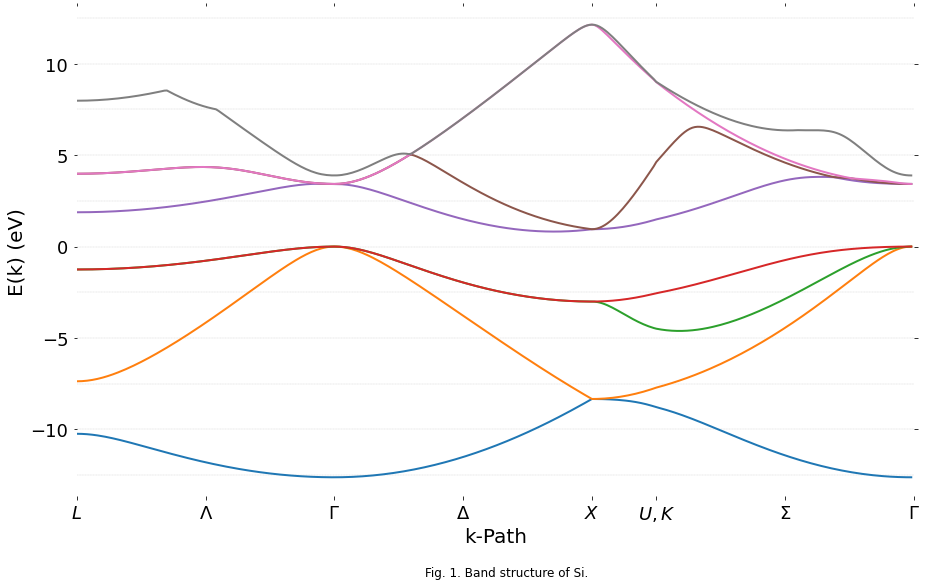

In [12]:
from matplotlib import pyplot as plt

%matplotlib inline

# offset the bands so that the top of the valence bands is at zero
bands -= max(bands[3])

plt.figure(figsize=(15, 9))

ax = plt.subplot(111)

# remove plot borders
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# limit plot area to data
plt.xlim(0, len(bands))
plt.ylim(min(bands[0]) - 1, max(bands[7]) + 1)

# custom tick names for k-points
xticks = n * np.array([0, 0.5, 1, 1.5, 2, 2.25, 2.75, 3.25])
plt.xticks(xticks, ('$L$', '$\Lambda$', '$\Gamma$', '$\Delta$', '$X$', '$U,K$', '$\Sigma$', '$\Gamma$'), fontsize=18)
plt.yticks(fontsize=18)

# horizontal guide lines every 2.5 eV
for y in np.arange(-25, 25, 2.5):
    plt.axhline(y, ls='--', lw=0.3, color='black', alpha=0.3)

# hide ticks, unnecessary with gridlines
plt.tick_params(axis='both', which='both',
                top='off', bottom='off', left='off', right='off',
                labelbottom='on', labelleft='on', pad=5)

plt.xlabel('k-Path', fontsize=20)
plt.ylabel('E(k) (eV)', fontsize=20)

plt.text(135, -18, 'Fig. 1. Band structure of Si.', fontsize=12)

# tableau 10 in fractional (r, g, b)
colors = 1 / 255 * np.array([
    [31, 119, 180],
    [255, 127, 14],
    [44, 160, 44],
    [214, 39, 40],
    [148, 103, 189],
    [140, 86, 75],
    [227, 119, 194],
    [127, 127, 127],
    [188, 189, 34],
    [23, 190, 207]
])

for band, color in zip(bands, colors):
    plt.plot(band, lw=2.0, color=color)

plt.show()

## IV. Results

The calculated band structure is given in Fig. 1.

Convergence to within 0.1 eV for each energy splitting was acheived with seven states (within 0.15 eV with five). Subsequent odd-numbered states improved the convergence by additional orders of magnitude. All of my calculated values, save for the $\Gamma_{25'}-X_1$ splitting, were found to be within 5% of those calculated by Cohen and Bergstresser$^1$. Calculated band splittings are given in Fig. 2.


 | $\Gamma_{25'}-\Gamma_{2'}$ | $\Gamma_{25'}-\Gamma_{15}$ | $\Gamma_{25'}-L_1$ | $\Gamma_{25'}-X_1$ | $L_{3'}-L_1$ | $L_{3'}-L_3$ | $X_4-X_1$
:--- | ---: | ---: | ---: | ---: | ---: | ---: | ---:
Calculated | 3.89 | 3.42 | 1.88 | 0.95 | 3.13 | 5.23 | 3.95
Cohen and Bergstresser$^1$ | 3.8 | 3.4 | 1.9 | 0.8 | 3.1 | 5.2 | 4.0

$$\scriptsize \text{Fig. 2. Energy splittings in eV between high-symmetry points of Silicon.}$$

At lower values of states, there appears to be a discontinuity at the $U$/$K$ symmetry point, marked by a slight but clear shift in all eight bands at the point. With a large number of sample points along each path this may become less apparent at lower state values. The blip seems to have all but disappeared when plotted at the converging parameters.

Silicon has an indirect band gap, with a valence band peak at the $\Gamma$ point and a conduction band minimum in the direction of the $X$ point. The band gap was found to be 0.82 eV, a far cry from its accepted value of 1.11 eV. This discrepancy is likely made up in more advanced pseudopotential methods that account for the effects of spin-orbit coupling.

## V. Conclusion

The pseudopotential method is surprisingly accurate for the minimal computation required. The empirical approach grounds the calculations in reality, and the values derived very neatly match those from experimentation. This method has no upper limit, either -- the series expansions of the Hamiltonian extend to an infinite number of plane waves. As computational power increases, so too can the accuracy of pseudopotential calculations.

Hardware is not the only useful tool; access to high-performance code is a necessity. As the availability of high-level wrappers to Fortran and C libraries increases, and numerous advancements are made in the field of computer science, your average computational physicist will experience a golden age of choices in which languages and tools they will use.

## VI. References

1. M.L. Cohen and T.K. Bergstresser, "Band Structures and Pseudopotential Form Factors for Fourteen Semiconductors of the Diamond and Zinc-blende Structures," Phys. Rev. 141, 789 (1966)
2. D. Brust, "Electronic Spectra of Crystalline Germanium and Silicon," Phys. Rev. 134, A1337 (1964)
3. A. Danner, "An introduction to the empirical pseudopotential method," https://www.ece.nus.edu.sg/stfpage/eleadj/pseudopotential.htm, downloaded November, 2015